# FY 2025 Hospital Readmission Predictor  
(30-day readmissions, HRRP measures)

*Dataset*: `FY_2025_csv.csv`  
*Target*: `Number of Readmissions`

In [39]:
# Core
import pandas as pd
import numpy as np

# Modeling
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

# Widen display
pd.set_option('display.max_columns', None)

In [40]:
df_raw = pd.read_csv('C:\\Users\\Hp\\Desktop\\MyWorkspaces\\My Analyst Project\\Hospital Data\\data\\csv\\FY_2025_csv.csv')
print(df_raw.shape)
df_raw.head()

(18510, 12)


,Facility Name,Facility ID,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
0,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-AMI-HRRP,296.0,NaN,0.9483,13.0146,13.7235,36,07/01/2020,06/30/2023
1,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-CABG-HRRP,151.0,NaN,0.9509,9.6899,10.1898,13,07/01/2020,06/30/2023
2,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-HF-HRRP,681.0,NaN,1.0597,21.5645,20.3495,151,07/01/2020,06/30/2023
3,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-HIP-KNEE-HRRP,NaN,NaN,0.9654,4.2680,4.4211,Too Few to Report,07/01/2020,06/30/2023
4,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-PN-HRRP,490.0,NaN,0.9715,16.1137,16.5863,77,07/01/2020,06/30/2023


### Quick sanity checks
- How many numeric vs. categorical columns?  
- Which columns have missing values?

In [41]:
df_raw.info()
df_raw.isna().sum().sort_values(ascending=False).head(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18510 entries, 0 to 18509
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Facility Name               18510 non-null  object 
 1   Facility ID                 18510 non-null  int64  
 2   State                       18510 non-null  object 
 3   Measure Name                18510 non-null  object 
 4   Number of Discharges        8340 non-null   float64
 5   Footnote                    6583 non-null   float64
 6   Excess Readmission Ratio    11927 non-null  float64
 7   Predicted Readmission Rate  11927 non-null  float64
 8   Expected Readmission Rate   11927 non-null  float64
 9   Number of Readmissions      11927 non-null  object 
 10  Start Date                  18510 non-null  object 
 11  End Date                    18510 non-null  object 
dtypes: float64(5), int64(1), object(6)
memory usage: 1.7+ MB


Footnote                      11927
Number of Discharges          10170
Excess Readmission Ratio       6583
Predicted Readmission Rate     6583
Expected Readmission Rate      6583
Number of Readmissions         6583
Facility Name                     0
Facility ID                       0
State                             0
Measure Name                      0
Start Date                        0
End Date                          0
dtype: int64

In [42]:
def clean(df):
    """Minimal cleaning pipeline."""
    df = df.copy()

    # Drop rows where target is missing
    df = df[df['Number of Readmissions'].notna()]

    # Convert 'Too Few to Report' → NaN in numeric columns
    numeric_cols = ['Excess Readmission Ratio', 'Predicted Readmission Rate',
                    'Expected Readmission Rate', 'Number of Discharges',
                    'Number of Readmissions']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Fill remaining NaNs
    df['Footnote'] = df['Footnote'].astype('category')
    df['Measure Name'] = df['Measure Name'].astype('category')
    df['Facility Name'] = df['Facility Name'].astype('category')
    df['State'] = df['State'].astype('category')
    
    # Ensure no NaNs in the target column
    df = df.dropna(subset=['Number of Readmissions'])
    
    return df

print("NaN values in target before cleaning:", df_raw['Number of Readmissions'].isna().sum())
df = clean(df_raw)
print("NaN values in target after cleaning:", df['Number of Readmissions'].isna().sum())
print("Rows after cleaning:", df.shape[0])

NaN values in target before cleaning: 6583
NaN values in target after cleaning: 0
Rows after cleaning: 8121


**Features used**  
categorical: `State`, `Measure Name`  
numerical: all the rest (ratios, rates, discharge volume)  

I *do not* include `Expected Readmission Rate` in training features to avoid label leakage.

In [43]:
TARGET = 'Number of Readmissions'

# Columns we DO NOT want as predictors
non_features = [TARGET,
                'Start Date', 'End Date', 'Footnote',
                'Facility Name', 'Facility ID']    # <- add these

y = df[TARGET]
X = df.drop(columns=non_features)

# Identify column types
cat_cols = ['State', 'Measure Name']
num_cols = [c for c in X.columns if X[c].dtype != 'category' and c not in cat_cols]

In [44]:
#Preprocess the data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

model = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

pipe = Pipeline(steps=[('prep', preprocessor),
                      ('clf', model)])

In [ ]:
# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

neg_mae = cross_val_score(pipe, X, y,
                          cv=cv,
                          scoring='neg_mean_absolute_error',
                          n_jobs=-1)

mae = -neg_mae
print("Mean Absolute Error (5-fold):", mae.mean().round(2))
print("Std:", mae.std().round(2))

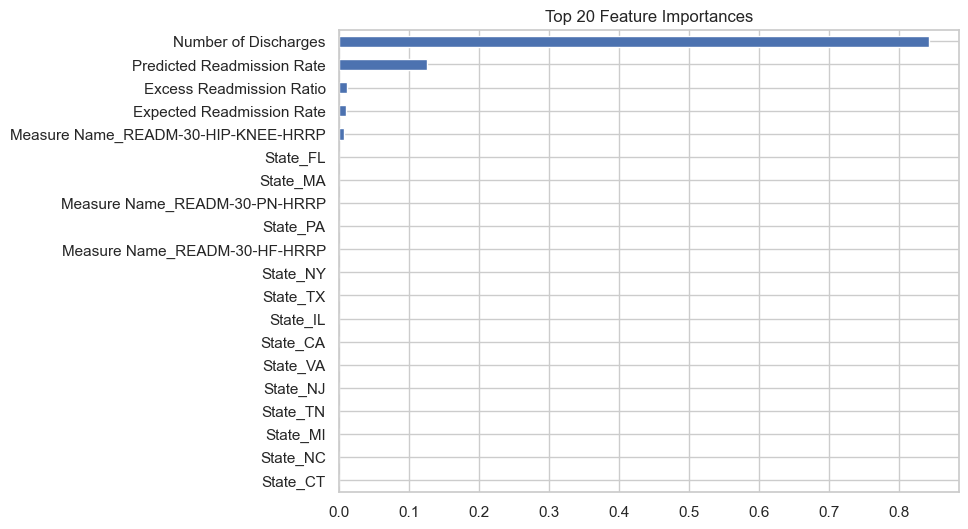

In [ ]:
# Fit the model to the entire dataset
pipe.fit(X, y)

# Pull out feature names after one-hot encoding
ohe = pipe.named_steps['prep'].named_transformers_['cat']
cat_features = ohe.get_feature_names_out(cat_cols)
all_features = num_cols + list(cat_features)

importances = pipe.named_steps['clf'].feature_importances_
feat_df = pd.Series(importances, index=all_features).sort_values(ascending=False)

plt.figure(figsize=(8,6))
feat_df.head(20).plot(kind='barh')
plt.title("Top 20 Feature Importances")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
import joblib
joblib.dump(pipe, 'fy2025_readmission_rf.pkl')
print("Model saved to fy2025_readmission_rf.pkl")

Model saved to fy2025_readmission_rf.pkl


### Predict readmissions for a hypothetical new record

In [2]:
# Example dummy row
new_row = {
    'State': 'CA',
    'Measure Name': 'READM-30-HF-HRRP',
    'Excess Readmission Ratio': 1.05,
    'Predicted Readmission Rate': 20.0,
    'Expected Readmission Rate': 19.0,
    'Number of Discharges': 500,
    'Facility Name': 'Test Hospital',
    'Facility ID': 999999
}

new_df = pd.DataFrame([new_row])
pred = pipe.predict(new_df)
print("Predicted # readmissions:", int(pred[0]))

NameError: name 'pd' is not defined

#### Ideas for improvement
- Hyper-parameter tuning via `RandomizedSearchCV`  
- Try Gradient-Boosting (XGBoost, LightGBM)  
- Add interaction terms (e.g., `Excess Ratio × Discharges`)  
- Separate models per `Measure Name` for higher accuracy